# Demo: So Sánh Phương Pháp MoE + Plugin vs Paper Method (CE + Plugin)

Notebook này demo việc so sánh phương pháp của bạn (3 Experts + Gating + Plugin) với paper method (CE + Plugin) trên một ảnh tail class.

## Nội dung:
1. Setup và imports
2. Load models và data
3. Chạy Paper Method (CE + Plugin)
4. Chạy Our Method (MoE + Plugin)
5. So sánh từng metric riêng biệt
6. Visualization

## 1. Setup và Imports

In [1]:
# Setup imports
import sys
from pathlib import Path
import json
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
import seaborn as sns

# Import demo functions
from demo_single_image_comparison import (
    load_class_to_group,
    load_test_sample_with_image,
    load_ce_expert,
    load_all_experts,
    load_gating_network,
    load_plugin_params,
    load_ce_only_plugin_params,
    paper_method_pipeline,
    our_method_pipeline,
    visualize_comparison,
    DATASET, DEVICE, OUTPUT_DIR, EXPERT_DISPLAY_NAMES
)

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 10)

print("✅ Imports successful!")

✅ Imports successful!


## 2. Configuration

In [12]:
# Configuration
class_idx = 36  # None = random tail class, or specify class index (e.g., 95)
seed = 42

# Set random seed
torch.manual_seed(seed)
np.random.seed(seed)

print(f"📁 Dataset: {DATASET}")
print(f"📁 Device: {DEVICE}")

📁 Dataset: cifar100_lt_if100
📁 Device: cpu


## 3. Load Data

In [13]:
# Load class-to-group mapping
class_to_group = load_class_to_group()

# Load CIFAR-100 class names
dataset = torchvision.datasets.CIFAR100(root="./data", train=False, download=False)
class_names = dataset.classes

# Load a tail class sample
image_tensor, true_label, image_array, class_name = load_test_sample_with_image(class_idx=class_idx)

# Check if it's tail
is_tail = class_to_group[true_label].item() == 1
print(f"\n{'✅ Tail class' if is_tail else '⚠️  Not tail class'} - Group: {class_to_group[true_label].item()}")

📊 Groups: 69 head classes, 31 tail classes
📊 Groups: 69 head classes, 31 tail classes
🎯 Selected class: 36

📷 Selected sample:
   Class: 36 (hamster) - head
   True label: 36
   Image shape: (32, 32, 3)

⚠️  Not tail class - Group: 0


## 4. Load Models

In [14]:
# Load models
print("\n" + "="*70)
print("Loading Models...")
print("="*70)

ce_expert = load_ce_expert()
experts = load_all_experts()
gating = load_gating_network()

# Load plugin parameters for both methods
ce_plugin_alpha, ce_plugin_mu, ce_plugin_cost = load_ce_only_plugin_params()
moe_plugin_alpha, moe_plugin_mu, moe_plugin_cost = load_plugin_params()


Loading Models...
✅ Loaded CE expert from checkpoints/experts/cifar100_lt_if100/final_calibrated_ce_baseline.pth
✅ Loaded ce_baseline expert
✅ Loaded logitadjust_baseline expert
✅ Loaded balsoftmax_baseline expert
✅ Loaded gating network from checkpoints/gating_map/cifar100_lt_if100/final_gating.pth
✅ Loaded CE-only plugin params from results/ltr_plugin/cifar100_lt_if100/ltr_plugin_ce_only_balanced.json
   α = [1.52079495 0.03837564], μ = [ 0. 20.], cost = 0.3486
✅ Loaded plugin params from results/ltr_plugin/cifar100_lt_if100/ltr_plugin_gating_balanced.json
   α = [1.5179404  0.03280266], μ = [ 0.   11.25], cost = 6.4856


## 5. Paper Method (CE + Plugin)

In [15]:
# Run Paper Method
print("\n" + "="*70)
print("📊 PAPER METHOD (CE + Plugin)")
print("="*70)

paper_result = paper_method_pipeline(
    image_tensor, 
    ce_expert, 
    class_to_group,
    ce_plugin_alpha, 
    ce_plugin_mu, 
    ce_plugin_cost
)

print(f"\nPrediction: Class {paper_result['prediction']} ({class_names[paper_result['prediction']]})")
print(f"Max Probability: {paper_result['confidence']:.4f}")
if 'plugin_confidence' in paper_result:
    print(f"Plugin Reweighted Score: {paper_result['plugin_confidence']:.4f}")
print(f"Reject: {'YES' if paper_result['reject'] else 'NO'}")
is_correct = paper_result['prediction'] == true_label
print(f"Correct: {'[YES]' if is_correct else '[NO]'}")


📊 PAPER METHOD (CE + Plugin)

Prediction: Class 36 (hamster)
Max Probability: 0.9708
Plugin Reweighted Score: 1.2767
Reject: NO
Correct: [YES]


## 6. Our Method (MoE + Plugin)

In [16]:
# Run Our Method
print("\n" + "="*70)
print("🚀 OUR METHOD (MoE + Gating + Plugin)")
print("="*70)

our_result = our_method_pipeline(
    image_tensor, 
    experts, 
    gating, 
    class_to_group,
    moe_plugin_alpha, 
    moe_plugin_mu, 
    moe_plugin_cost
)

print(f"\nExpert Predictions: {our_result['expert_predictions']} ({EXPERT_DISPLAY_NAMES})")
print(f"Gating Weights: {our_result['gating_weights']}")
print(f"Plugin Prediction: Class {our_result['prediction']} ({class_names[our_result['prediction']]})")
print(f"Max Probability: {our_result['confidence']:.4f}")
if 'plugin_confidence' in our_result:
    print(f"Plugin Reweighted Score: {our_result['plugin_confidence']:.4f}")
print(f"Reject: {'YES' if our_result['reject'] else 'NO'}")
is_correct = our_result['prediction'] == true_label
print(f"Correct: {'[YES]' if is_correct else '[NO]'}")


🚀 OUR METHOD (MoE + Gating + Plugin)

Expert Predictions: [36, 36, 36] (['CE', 'LogitAdjust', 'BalancedSoftmax'])
Gating Weights: [0.92032707 0.06397038 0.01570255]
Plugin Prediction: Class 36 (hamster)
Max Probability: 0.9370
Plugin Reweighted Score: 1.2345
Reject: NO
Correct: [YES]


## 7. So Sánh Metrics

### 7.1 Prediction Accuracy

In [17]:
# Prediction Accuracy Comparison
paper_correct = paper_result['prediction'] == true_label
our_correct = our_result['prediction'] == true_label

print("📊 Prediction Accuracy:")
print(f"   Paper Method: {'✅ CORRECT' if paper_correct else '❌ WRONG'}")
print(f"   Our Method:   {'✅ CORRECT' if our_correct else '❌ WRONG'}")

if paper_correct and not our_correct:
    print("\n   ⚠️  Paper method is correct, our method is wrong")
elif not paper_correct and our_correct:
    print("\n   ✅ Our method is correct, paper method is wrong!")
elif paper_correct and our_correct:
    print("\n   ✅ Both methods are correct")
else:
    print("\n   ❌ Both methods are wrong")

📊 Prediction Accuracy:
   Paper Method: ✅ CORRECT
   Our Method:   ✅ CORRECT

   ✅ Both methods are correct


### 7.2 Max Probability

📊 Max Probability (Actual Confidence):
   Paper Method: 0.9708
   Our Method:   0.9370
   Difference:   -0.0339


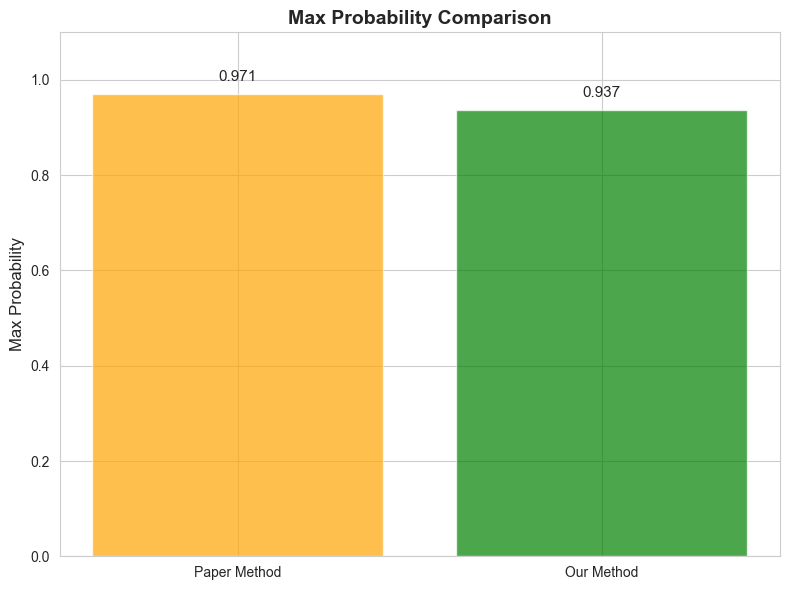

In [18]:
# Max Probability Comparison
paper_prob = paper_result['confidence']
our_prob = our_result['confidence']

print("📊 Max Probability (Actual Confidence):")
print(f"   Paper Method: {paper_prob:.4f}")
print(f"   Our Method:   {our_prob:.4f}")
print(f"   Difference:   {our_prob - paper_prob:+.4f}")

# Visualize
fig, ax = plt.subplots(figsize=(8, 6))
methods = ['Paper Method', 'Our Method']
probs = [paper_prob, our_prob]
colors = ['orange', 'green']
bars = ax.bar(methods, probs, color=colors, alpha=0.7)
ax.set_ylabel('Max Probability', fontsize=12)
ax.set_title('Max Probability Comparison', fontsize=14, fontweight='bold')
ax.set_ylim([0, 1.1])
for bar, prob in zip(bars, probs):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
            f'{prob:.3f}', ha='center', va='bottom', fontsize=11)
plt.tight_layout()
plt.show()

### 7.3 Plugin Reweighted Score (Có thể > 1)

In [24]:
# Plugin Reweighted Score Comparison
paper_reweighted = paper_result.get('plugin_confidence', None)
our_reweighted = our_result.get('plugin_confidence', None)

print("📊 Plugin Reweighted Score (can be > 1):")
if paper_reweighted is not None:
    print(f"   Paper Method: {paper_reweighted:.4f}")
else:
    print(f"   Paper Method: N/A")
if our_reweighted is not None:
    print(f"   Our Method:   {our_reweighted:.4f}")
else:
    print(f"   Our Method:   N/A")

if paper_reweighted is not None and our_reweighted is not None:
    print(f"   Difference:   {our_reweighted - paper_reweighted:+.4f}")
    print(f"\n   💡 Note: Reweighted score = (1/α̂[y]) * p_y(x), can be > 1")

📊 Plugin Reweighted Score (can be > 1):
   Paper Method: 1.2767
   Our Method:   1.2345
   Difference:   -0.0422

   💡 Note: Reweighted score = (1/α̂[y]) * p_y(x), can be > 1


### 7.4 Rejection Decision

In [23]:
# Rejection Decision Comparison
paper_reject = paper_result['reject']
our_reject = our_result['reject']

print("📊 Rejection Decision:")
print(f"   Paper Method: {'REJECT' if paper_reject else 'ACCEPT'}")
print(f"   Our Method:   {'REJECT' if our_reject else 'ACCEPT'}")

if paper_reject == our_reject:
    print(f"\n   ✅ Both methods {'REJECT' if paper_reject else 'ACCEPT'}")
else:
    print(f"\n   ⚠️  Different decisions")

📊 Rejection Decision:
   Paper Method: ACCEPT
   Our Method:   ACCEPT

   ✅ Both methods ACCEPT


### 7.5 Expert Contributions (Our Method Only)

📊 Expert Contributions:
   CE:
      Prediction: 36 (hamster) ✅
      Gating Weight: 0.9203
      Max Probability: 0.9708
   LogitAdjust:
      Prediction: 36 (hamster) ✅
      Gating Weight: 0.0640
      Max Probability: 0.5736
   BalancedSoftmax:
      Prediction: 36 (hamster) ✅
      Gating Weight: 0.0157
      Max Probability: 0.4318


/var/folders/bw/q82tr8kx6ll_854mt69fk2_r0000gn/T/ipykernel_1181/385168248.py:40: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
/opt/anaconda3/envs/DEGRE/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


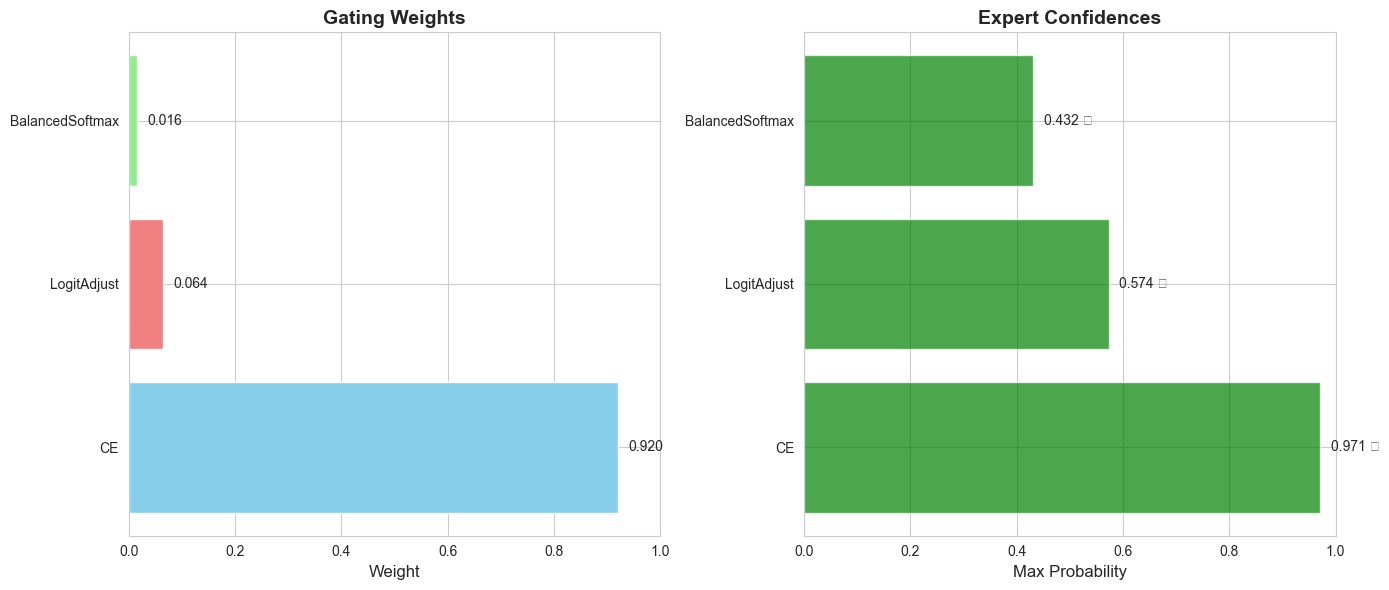

In [21]:
# Expert Contributions
expert_names = EXPERT_DISPLAY_NAMES
expert_preds = our_result['expert_predictions']
gating_weights = our_result['gating_weights']
expert_probs = our_result['expert_probs']

print("📊 Expert Contributions:")
for i, (name, pred, weight, probs) in enumerate(zip(expert_names, expert_preds, gating_weights, expert_probs)):
    correct = '✅' if pred == true_label else '❌'
    max_prob = np.max(probs)
    print(f"   {name}:")
    print(f"      Prediction: {pred} ({class_names[pred]}) {correct}")
    print(f"      Gating Weight: {weight:.4f}")
    print(f"      Max Probability: {max_prob:.4f}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Gating weights
ax1 = axes[0]
ax1.barh(expert_names, gating_weights, color=['skyblue', 'lightcoral', 'lightgreen'])
ax1.set_xlabel('Weight', fontsize=12)
ax1.set_title('Gating Weights', fontsize=14, fontweight='bold')
ax1.set_xlim([0, 1])
for i, (name, weight) in enumerate(zip(expert_names, gating_weights)):
    ax1.text(weight + 0.02, i, f'{weight:.3f}', va='center', fontsize=10)

# Expert confidences
ax2 = axes[1]
expert_confidences = [np.max(probs) for probs in expert_probs]
colors = ['green' if pred == true_label else 'red' for pred in expert_preds]
ax2.barh(expert_names, expert_confidences, color=colors, alpha=0.7)
ax2.set_xlabel('Max Probability', fontsize=12)
ax2.set_title('Expert Confidences', fontsize=14, fontweight='bold')
ax2.set_xlim([0, 1])
for i, (name, conf, pred) in enumerate(zip(expert_names, expert_confidences, expert_preds)):
    status = '✅' if pred == true_label else '❌'
    ax2.text(conf + 0.02, i, f'{conf:.3f} {status}', va='center', fontsize=10)

plt.tight_layout()
plt.show()